Use default mcK setting, 
Except:
- longer summer 
- wghts_std_anom = True
- wghts_accross_lags = True

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 10 10:31:42 2018

@author: semvijverberg
"""

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 13 14:40:40 2018

@author: semvijverberg
"""

import os, sys
os.chdir('/Users/semvijverberg/surfdrive/Scripts/Extracting_precursor/')
script_dir = os.getcwd()
if sys.version[:1] == '3':
    from importlib import reload as rel
import func_mcK
from ROC_score import ROC_score_wrapper
import numpy as np
import xarray as xr 
import pandas as pd
import cartopy.crs as ccrs
xrplot = func_mcK.xarray_plot
import matplotlib.pyplot as plt
import scipy

base_path = "/Users/semvijverberg/surfdrive/Data_ERAint/"
exp_folder = ''
path_raw = os.path.join(base_path, 'input_raw')
path_pp  = os.path.join(base_path, 'input_pp')
if os.path.isdir(path_raw) == False : os.makedirs(path_raw) 
if os.path.isdir(path_pp) == False: os.makedirs(path_pp)
map_proj = ccrs.Miller(central_longitude=240)  


ex_dic_path = "T95_sst_NOAA_default_settings.npy"
ex = np.load(ex_dic_path, encoding='latin1').item()

# change length of RV period:
ex['sstartdate'] = '1982-06-01'
ex['senddate']   = '1982-08-31'
ex['wghts_std_anom'] = True
ex['wghts_accross_lags'] = True

ex['figpathbase'] = os.path.join(ex['figpathbase'], '{}_{}'.format(
        ex['RV_name'], ex['name']))
if os.path.isdir(ex['figpathbase']) == False: os.makedirs(ex['figpathbase'])

#'Mckinnonplot', 'U.S.', 'U.S.cluster', 'PEPrectangle', 'Pacific', 'Whole', 'Northern', 'Southern'
def oneyr(datetime):
    return datetime.where(datetime.year==datetime.year[0]).dropna()


ex['region'] = 'Whole'
print(ex['region'])

# Load in mckinnon Time series
T95name = 'PEP-T95TimeSeries.txt'
mcKtsfull, datesmcK = func_mcK.read_T95(T95name, ex)
datesmcK_daily = func_mcK.make_datestr(datesmcK, ex)

# Selected Time series of T95 ex['sstartdate'] until ex['senddate']
mcKts = mcKtsfull.sel(time=datesmcK_daily)

# Load in external ncdf
#filename = '{}_1979-2017_2mar_31aug_dt-1days_2.5deg.nc'.format(ex['name'])
filename = '{}_1982-2017_2jan_31aug_dt-1days_2.5deg.nc'.format(ex['name'])
# full globe - full time series
varfullgl = func_mcK.import_array(filename, ex)

# filter out outliers of sst
if ex['name']=='sst':
    varfullgl.where(varfullgl.values < 3.5*varfullgl.std().values)



RV_ts, datesmcK = func_mcK.time_mean_bins(mcKts, ex)
expanded_time = func_mcK.expand_times_for_lags(datesmcK, ex)
# Converting Mckinnon timestemp to match xarray timestemp
expandeddaysmcK = func_mcK.to_datesmcK(expanded_time, expanded_time[0].hour, varfullgl.time[0].dt.hour)
# region mckinnon - expanded time series
Prec_reg = func_mcK.find_region(varfullgl.sel(time=expandeddaysmcK), region=ex['region'])[0]
Prec_reg, datesvar = func_mcK.time_mean_bins(Prec_reg, ex)


## plotting same figure as in paper
#func_mcK.plot_oneyr_events(RV_ts, ex['hotdaythres'], 2012)

    

print_ex = ['RV_name', 'name', 'grid_res', 'startyear', 'endyear', 
            'sstartdate', 'senddate', 'n_conv', 'wghts_std_anom', 
            'wghts_accross_lags', 'splittrainfeat', 'n_strongest',
            'n_std', 'tfreq', 'lags', 'n_yrs']
for key in print_ex:
    print('\'{}\'\t\t{}'.format(key, ex[key]))

    
#np.save(os.path.join(script_dir, '{}_{}_default_settings.npy'.format(
#        ex['RV_name'], ex['name'])), ex)

#%% Run code with ex settings
def main(RV_ts, Prec_reg, ex):
    if ex['leave_n_out'] == False : ex['n_conv'] = 1
    # Purely train-test based on iterating over all years:
    lats = Prec_reg.latitude
    lons = Prec_reg.longitude
    array = np.zeros( (ex['n_conv'], len(ex['lags']), len(lats), len(lons)) )
    patterns = xr.DataArray(data=array, coords=[range(ex['n_conv']), ex['lags'], lats, lons], 
                          dims=['n_tests', 'lag','latitude','longitude'], 
                          name='{}_tests_patterns'.format(ex['n_conv']), attrs={'units':'Kelvin'})
    
    for n in range(ex['n_conv']):
        ex['n'] = n

        # do single run
        # =============================================================================
        # Calculate Precursor
        # =============================================================================
        test, train, ds_mcK, ds_Sem, ex = func_mcK.find_precursor(RV_ts, Prec_reg, ex)
    
        # =============================================================================
        # Calculate ROC score
        # =============================================================================
        ex = ROC_score_wrapper(test, train, ds_mcK, ds_Sem, ex)
        l_ds_Sem       = [ex['score_per_run'][i][3] for i in range(len(ex['score_per_run']))]
        patterns[n,:,:,:] = l_ds_Sem[n]['pattern']
        
        
        ex['n'] += 1
    return ex, patterns

        
ex, patterns = main(RV_ts, Prec_reg, ex)

Whole
'RV_name'		T95
'name'		sst_NOAA
'grid_res'		2.5
'startyear'		1982
'endyear'		2015
'sstartdate'		1982-06-01
'senddate'		1982-08-31
'n_conv'		34
'wghts_std_anom'		True
'wghts_accross_lags'		True
'splittrainfeat'		False
'n_strongest'		15
'n_std'		1.5
'tfreq'		1
'lags'		[0, 6, 12, 18]
'n_yrs'		34
test year is [1982], with 3 events
test year is [1983], with 49 events
test year is [1984], with 18 events
test year is [1985], with 12 events
test year is [1986], with 9 events
test year is [1987], with 23 events
test year is [1988], with 63 events
test year is [1989], with 17 events
test year is [1990], with 16 events
test year is [1991], with 26 events
test year is [1992], with 2 events
test year is [1993], with 7 events
test year is [1994], with 7 events
test year is [1995], with 25 events
test year is [1996], with 7 events
test year is [1997], with 4 events
test year is [1998], with 7 events
test year is [1999], with 21 events
test year is [2000], with 17 events
test year is [2001], wit

# Simple mean over all runs

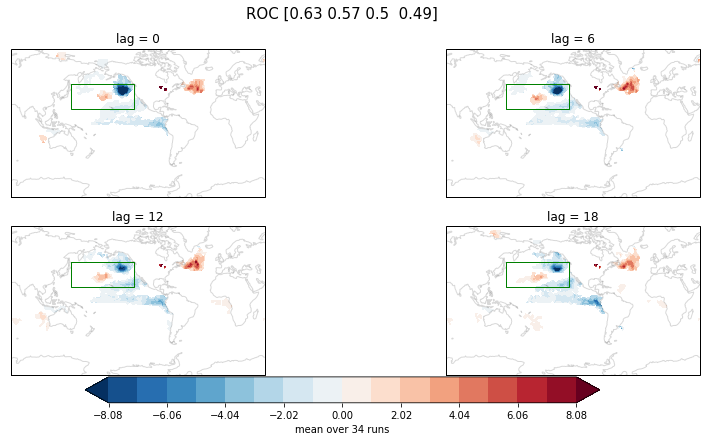

In [4]:
events_per_year = [ex['score_per_run'][i][1] for i in range(len(ex['score_per_run']))]
l_ds_mcK        = [ex['score_per_run'][i][2] for i in range(len(ex['score_per_run']))]
l_ds_Sem        = [ex['score_per_run'][i][3] for i in range(len(ex['score_per_run']))]
ran_ROCS        = [ex['score_per_run'][i][4] for i in range(len(ex['score_per_run']))]
score_mcK       = np.round(ex['score_per_run'][-1][2]['score'], 2)
score_Sem       = np.round(ex['score_per_run'][-1][3]['score'], 2)


mean_n_patterns = patterns.mean(dim='n_tests')
mean_n_patterns.attrs['units'] = 'mean over {} runs'.format(ex['n_conv'])
mean_n_patterns.name = 'ROC {}'.format(score_Sem.values)
filename = os.path.join(ex['exp_folder'], 'mean_over_{}_tests'.format(ex['n_conv']) )
func_mcK.plotting_wrapper(mean_n_patterns, filename, ex)

# Counting times gridcells were extracted

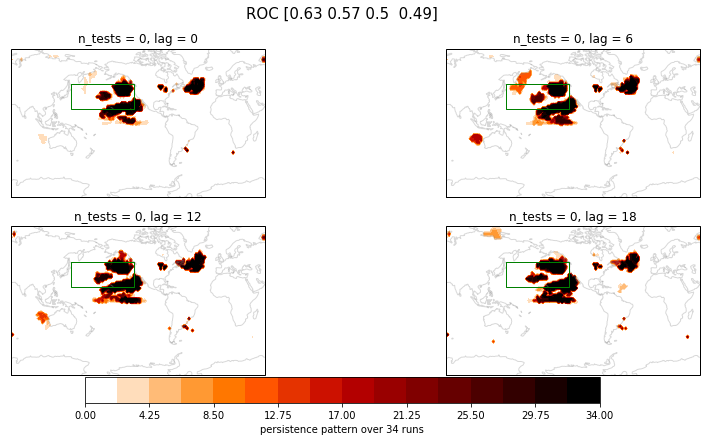

In [5]:
if ex['leave_n_out']:
    n_lags = patterns.sel(n_tests=0).lag.size
    n_lats = patterns.sel(n_tests=0).latitude.size
    n_lons = patterns.sel(n_tests=0).longitude.size
    
    pers_patt = patterns.sel(n_tests=0).copy()
    arrpatt = np.nan_to_num(patterns.values)
    mask_patt = (arrpatt != 0)
    arrpatt[mask_patt] = 1
    wghts = np.zeros( (n_lags, n_lats, n_lons) )
    #plt.imshow(arrpatt[0,0]) ; plt.colorbar()
    for l in ex['lags']:
        i = ex['lags'].index(l)
        wghts[i] = np.sum(arrpatt[:,i,:,:], axis=0)
    pers_patt.values = wghts
    
    pers_patt.attrs['units'] = 'persistence pattern over {} runs'.format(ex['n_conv'])
    pers_patt.attrs['title'] = 'ROC {}'.format(score_Sem.values)
    filename = os.path.join(ex['exp_folder'], 'mean_over_{}_tests'.format(ex['n_conv']) )
    kwrgs = dict( {'title' : pers_patt.name, 'clevels' : 'notdefault', 'steps':17,
                    'vmin' : pers_patt.min().values, 'vmax' : pers_patt.max().values, 
                   'cmap' : plt.cm.gist_heat_r, 'column' : 2} )
    func_mcK.plotting_wrapper(pers_patt, filename, ex, kwrgs=kwrgs)

# Only keep gridcells that were extracted every run

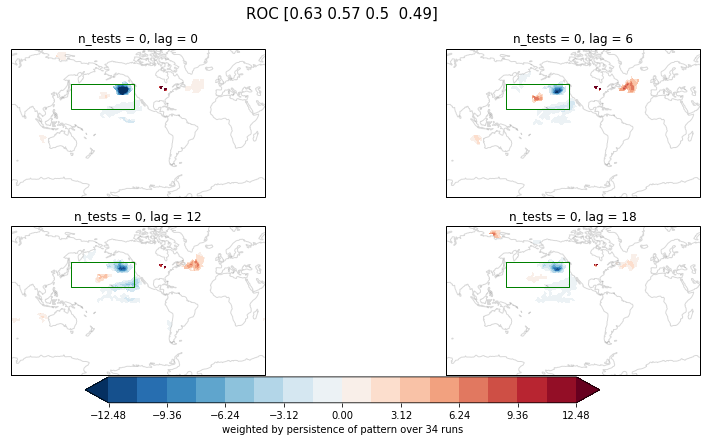

In [6]:
if ex['leave_n_out']:
    pers_patt_filter = patterns.sel(n_tests=0).copy()
    ex['persistence_criteria'] = len(set(RV_ts.time.dt.year.values))
    mask_pers = (wghts == ex['persistence_criteria'])
    mean_n_patterns = patterns.mean(dim='n_tests')
    mean_n_patterns.coords['mask'] = (('lag', 'latitude','longitude'), mask_pers)
    #pers_patt_filter = mask_pers * patterns.mean(dim='n_tests')
    pers_patt_filter.attrs['units'] = 'weighted by persistence of pattern over {} runs'.format(ex['n_conv'])
    pers_patt_filter.name = 'ROC {}'.format(score_Sem.values)
    func_mcK.plotting_wrapper(pers_patt_filter, filename, ex, kwrgs=None)